<a href="https://colab.research.google.com/github/xnasarx/Stock-Price-Predictor/blob/main/Python_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imported Libraries

import re
import os
import requests
import pandas as pd
from datetime import date
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

In [ ]:
# Utility functions related to scraping.

# This method sends a get request to a url and returns the response from server.
def scrape_url(uri, baseurl="https://www.prnewswire.com"):
    url = baseurl + uri
    response = requests.get(url)

    if response.status_code == 200:
        return response
    else:
        return False

# This method transforms the string html into parseable html code using beautiful soup library.
def create_beautiful_soup(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup

# This method checks if the article is posted within the specified time window from today's date.
def date_within_specific_window(article_date, window=2, window_unit="weeks"):
    today = datetime.now()
    if article_date > today - timedelta(weeks = 2):
        return True

    return False

# This loads the data of articles that have already been scraped into a pandas dataframe and returns it.
def load_existing_articles():
    filepath = "articles.csv"
    if os.path.exists(filepath):
        return pd.read_csv(filepath)
    else:
        return None


# This method extracts all the articles from list of articles on a given page of list of articles.
def get_all_news_articles(soup):
    all_articles = soup.find_all("div", {"class": "row arabiclistingcards", "lang": "en-US"})

    return all_articles
    
# This method extracts the date, url and text of a given  article and returns this data in a dictionary.
def get_date_url_text_for_article(article, baseurl = "https://www.prnewswire.com"):
    tmp = {}

    # Extract the date at which the article was posted
    extracted_date = article.find(text=re.compile("(\w{3}\s\d{2}\,\s\d{4},\s)?\d{2}\:\d{2}\s\w{2}"))


    _d = ""

    # If the extracted date is less than 10 characters in length, then that means it's missing the date and is
    # only mentioning time. In that case concatenate today's date to the start of the extracted date in the 
    # "MMM DD, YYYY" format
    if(len(extracted_date)<10):
        today_date = datetime.now()
        _d = today_date.strftime("%b %d, %Y,")
        news_date = _d + " " + extracted_date
    else:
        news_date = extracted_date

    # Conver the extracted date which was of string type to datetime type
    converted_date = datetime.strptime(news_date, '%b %d, %Y, %H:%M ET')

    # Check if the article posting date is within specified time window. If not ignore the article.
    if date_within_specific_window(converted_date):
        news_link = article.find("a", {"class": "newsreleaseconsolidatelink"})

        # Check if the article has already been scraped earlier.
        if news_link.get('href') not in scraped_urls:
            news_response = requests.get(baseurl + news_link.get('href'))

            scraped_urls.append(news_link.get('href'))

            news_soup = BeautifulSoup(news_response.content, 'html.parser')

            news_article = news_soup.find('article', {"class": "news-release"})
            
            # Check if the article page contains the actual text which contains the news article  
            if news_article is not None:
                news_text = news_article.get_text()
                return {
                    "article_valid": True,
                    "_continue": True,
                    "article_data":[news_date, baseurl + news_link.get('href'), news_text]
                }
            else:
                return {"article_valid":False,"_continue":True}
        else:
            return {"article_valid":False,"_continue":True}
    else:
        return {"article_valid":False,"_continue":False}

# This method loads scraped urls present in scraped_url.log file to a list and returns that list
def load_scraped_url_log():
    if os.path.exists("scraped_url.log"):
        with open("scraped_url.log","r") as f: 
            urls = f.readlines()
    else:
        urls = []

    return urls
        
# This method saves appends the existing urls in scraped_urls list to scraped_url.log file to 
# save them for future reference to make sure they are not scraped again. 
def save_scraped_url_log():
    with open("scraped_url.log","a+") as f:
        f.writelines([url+"\n" for url in scraped_urls])

In [ ]:
# Initialize Scraped urls log to avoid scraping previously scraped articles.
scraped_urls = load_scraped_url_log()


# List of stock exchanges that we are searching for.
stock_exchanges = {
    "NYSE": "New York Stock Exchange",
    "NASDAQ":"National Association of Securities Dealers Automated Quotations",
    "SSE":"Shanghai Stock Exchange",
    "EURONEXT":"European New Exchange Technology",
    "HKEX":"Hong Kong Stock Exchange",
    "TSE":"Tokyo Stock Exchange",
    "SZSE":"Shenzhen Stock Exchange",
    "LSE":"London Stock Exchange",
    "TSX":"Toronto Stock Exchange",
    "BSE":"Bombay Stock Exchange",
}


# List of all the tech stock symbols we are interested in.
stock_symbols = {
    "YRD" :"Yiren Digital Ltd",
    "AKAM":"Akamai", 
    "AMAT":"Applied Materials",
    "AMD":"Advanced Micro Devices",
    "AMRH":"Ameri holdings",
    "ANY":"Sphere 3D",
    "ARTX":"Arotech",
    "ATVI":"Activision",
    "CDNS":"Cadence",
    "CSCO":"Cisco",
    "CTSH":"Cognizant",
    "DXC":"DXC Technology",
    "EA":"Electronic Arts",
    "ENVA":"Enova International",
    "FLIR":"Flir Systems",
    "FTNT":"Fortinet",
    "GLUU":"Plug Power",
    "GLW":"Corning",
    "HPE":"Hewlett Packard Enter",
    "HPQ":"Hewlett Packard Co",
    "HON":"Honeywell",
    "INPX":"Inpixon",
    "INTC":"Intel Corp",
    "IQ":"iQiyi",
    "JNPR":"Juniper",
    "MU":"Micron Tech",
    "MXIM":"Maxim Integrated",
    "NTAP":"Netapp Inc",
    "OIIM":"O2 Micro",
    "ORCL":"Oracle",
    "PAYX":"Paychex",
    "PLUG":"Zix Corp",
    "QCOM":"Qualcomm",
    "QRVO":"Qorvo",
    "SCON":"Superconductor tech",
    "STNE":"StoneCo",
    "STX":"Seagate",
    "SWKS":"Skyworks Solutions",
    "SYMC":"Symantec",
    "TRIP":"TripAdvisor",
    "TRVG":"Trivago",
    "TWTR":"Twitter",
    "WDC":"Western Digital",
    "WU":"Western Union",
    "XRX":"Xerox",
    "ZIXI":"Zix Corp",
    "AAPL":"Apple",
    "ACN":"Accenture",
    "ADI":"Analog Devices",
    "ADP":"ADP Payroll",
    "ADS":"Alliance Data",
    "ADSK":"Autodesk",
    "ANET":"Arista",
    "ANSS":"Ansys",
    "APH":"Amphenol",
    "BABA":"Alibaba",
    "BIDU":"Baidu",
    "BR":"Broadridge",
    "BBW":"Build A Bear Workshop, Inc",
    "CRM":"SalesForce",
    "CTXS":"Citrix",
    "FB":"Facebook",
    "FFIV":"F5 Networks",
    "FIS":"Fidelity National Information Services",
    "FISV":"Fiserv",
    "GPN":"Global Payments",
    "IBM":"Intl Business Machines",
    "INTU":"Intuit",
    "IPGP":"IPG Photonics",
    "IT":"Gartner",
    "JKHY":"Jack Henry",
    "KEYS":"Keysight Tech",
    "KLAC":"KLA Tencor",
    "LRCX":"Lam Research",
    "MA":"Mastercard",
    "MCHP":"Microchip Tech",
    "MSFT":"Microsoft",
    "MSI":"Motorola",
    "NVDA":"Nvidia",
    "NXPI":"NXP Semiconductors",
    "PYPL":"PayPal",
    "SIXT":"Tech Sector Index Tracking",
    "SNPS":"Synopsys",
    "TEL":"TE Connectivity",
    "TSS":"Total System Services",
    "TTWO":"Take Two Interactive Software",
    "TXN":"Texas Instruments",
    "V":"Visa",
    "VIAV":"Viavi Solutions",
    "VRSN":"Verisign",
    "XLNX":"Xilinx Inc",
} 

In [ ]:
pagenum = 1
scrape_continue = True

PAGE_LIMIT = 20

while (scrape_continue and (pagenum < PAGE_LIMIT)):
    news = {
        "date":[],
        "url":[],
        "text":[]
    } 
    list_uri = "/news-releases/consumer-technology-latest-news/consumer-technology-latest-news-list/?page={}&pagesize=100".format(pagenum)

    response = scrape_url(list_uri)

    if response:
        soup = create_beautiful_soup(response.content)

        all_articles = get_all_news_articles(soup)
        for article in all_articles:
            if scrape_continue:
                article_response = get_date_url_text_for_article(article)
                article_valid = article_response["article_valid"]
                scrape_continue = article_response["_continue"]
                if article_valid:
                    article_data = article_response["article_data"]
                    news['date'].append(article_data[0])
                    news['url'].append(article_data[1])
                    news['text'].append(article_data[2])
            else:
                break
    else:
        break

    pagenum += 1 


    # Amin's Code Start Here

    df_news = load_existing_articles()

    if df_news is not None:
        df_news = pd.concat([df_news,pd.DataFrame.from_dict(news)])
    else:
        df_news = pd.DataFrame.from_dict(news)
      
    df_news.to_csv("articles.csv", index=False)

    print("Scan Complete for url {} | \nCurrent Articles in collection: {}".format(list_uri, df_news.shape[0]))

    df_news = None


Scan Complete for url /news-releases/consumer-technology-latest-news/consumer-technology-latest-news-list/?page=1&pagesize=100 | 
Current Articles in collection: 778
Scan Complete for url /news-releases/consumer-technology-latest-news/consumer-technology-latest-news-list/?page=2&pagesize=100 | 
Current Articles in collection: 778
Scan Complete for url /news-releases/consumer-technology-latest-news/consumer-technology-latest-news-list/?page=3&pagesize=100 | 
Current Articles in collection: 778
Scan Complete for url /news-releases/consumer-technology-latest-news/consumer-technology-latest-news-list/?page=4&pagesize=100 | 
Current Articles in collection: 778
Scan Complete for url /news-releases/consumer-technology-latest-news/consumer-technology-latest-news-list/?page=5&pagesize=100 | 
Current Articles in collection: 779
Scan Complete for url /news-releases/consumer-technology-latest-news/consumer-technology-latest-news-list/?page=6&pagesize=100 | 
Current Articles in collection: 779
Scan

In [ ]:
save_scraped_url_log()

In [ ]:
# Search for Stock in Text

df_news = load_existing_articles()

text = list(df_news['text'])

stocks_list = []

# For loop for every stock exchange in stock_exchanges dictionary
for exchange_abbr, exchange_name in stock_exchanges.items():
    # For loop for every interesting stock in stock_symbols dictionary
    for stock, company in stock_symbols.items():
        # For loop for text for all articles stored in articles.csv
        for idx,t in enumerate(text):
            # Searching 
            search_pattern = re.compile("("+exchange_abbr+")\s?:\s?("+stock+")")
            m = re.findall(search_pattern, t)
            if len(m)>0:
                stocks_list.append(stock)
                print("Found {} ({}:{}) in article {}".format(company,exchange_abbr,stock,df_news.iloc[idx]['url']))

# Remove duplicate stock tickers
stocks_list = list(set(stocks_list))
stocks_list = stocks_list[0:2]

Found DXC Technology (NYSE:DXC) in article https://www.prnewswire.com/news-releases/dxc-technology-announces-lockton-uk-as-first-customer-to-use-new-dxc-assure-broking-solution-301700065.html
Found Enova International (NYSE:ENVA) in article https://www.prnewswire.com/news-releases/enova-announces-of-decade-of-recognition-as-one-of-computerworlds-best-places-to-work-in-it-301703430.html
Found Oracle (NYSE:ORCL) in article https://www.prnewswire.com/news-releases/oracle-announces-fiscal-2023-second-quarter-financial-results-301700760.html
Found Broadridge (NYSE:BR) in article https://www.prnewswire.com/news-releases/amid-a-volatile-market-financial-advisors-are-finding-ways-to-generate-new-aum-301702145.html
Found Broadridge (NYSE:BR) in article https://www.prnewswire.com/news-releases/broadridge-and-strate-connect-to-streamline-the-proxy-voting-lifecycle-in-south-africa-301702423.html
Found Broadridge (NYSE:BR) in article https://www.prnewswire.com/news-releases/broadridge-named-a-leade

In [ ]:
#Installing Libraries
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
#Importing Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Retrieve and store data for the stocks in a dictionary

# stocks_list = ['AAPL','MSFT']
stocks_data = {}

for stock in stocks_list: #Loop over the list of the stocks
  data = yf.Ticker(stock) #Call Yahoo Finance to fetch all data
  stocks_data[stock] = data.history(period="6mo") #Filter the last 6 months data 


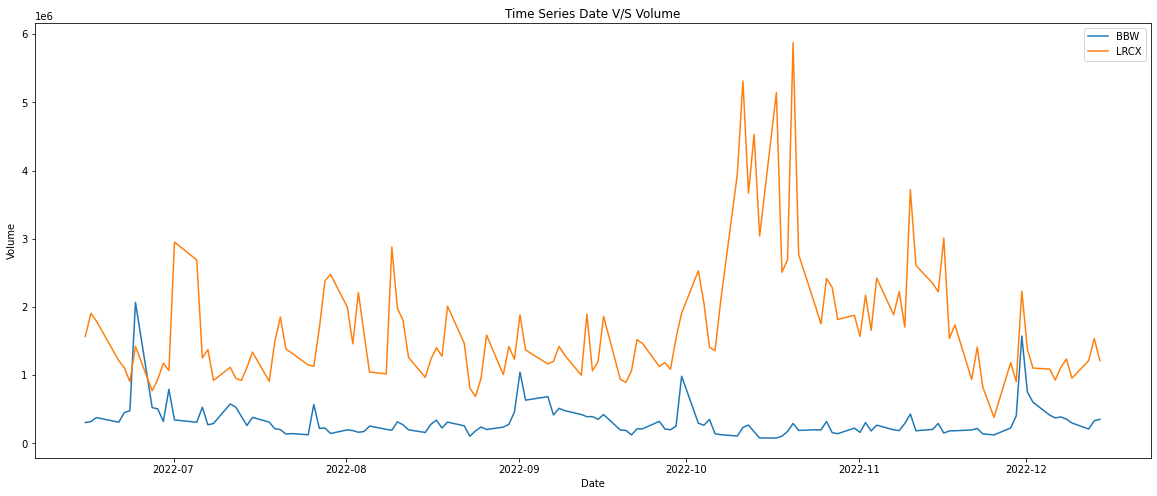

In [ ]:
plt.rcParams["figure.figsize"] = (20,8) #graph size
for stock in stocks_list: 
  plt.plot(stocks_data[stock]['Volume'], label = stock) #creating a time series graphs for volume

plt.xlabel("Date") #x axis label
plt.ylabel("Volume") #y axis label
plt.legend() #places a legend on the graph
plt.title("Time Series Date V/S Volume") #title of the graph5
plt.show()


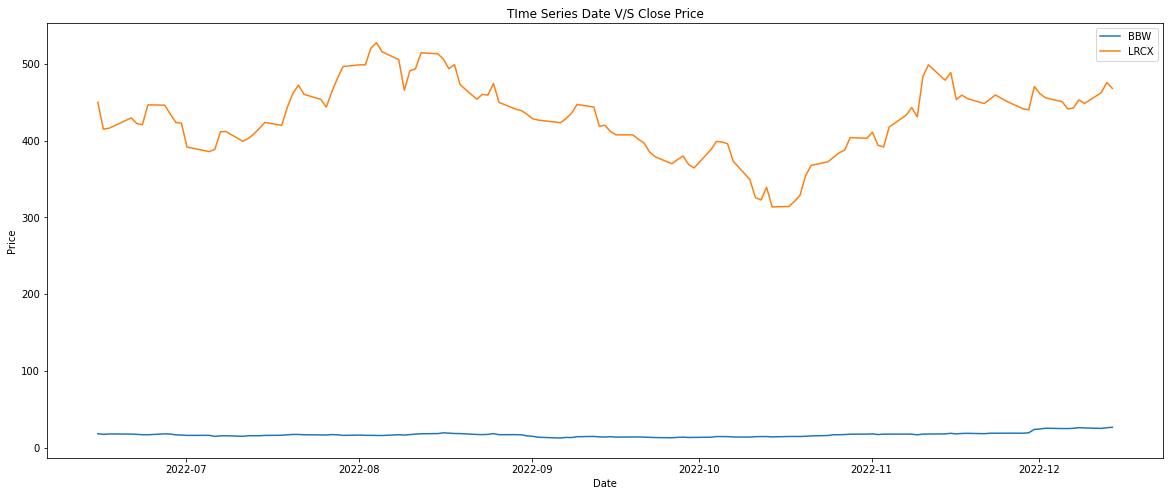

In [ ]:
plt.rcParams["figure.figsize"] = (20,8)
for stock in stocks_list:
  plt.plot(stocks_data[stock]['Close'], label = stock) #time series graph for close price

plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()  
plt.title("TIme Series Date V/S Close Price")
plt.show()



In [ ]:
#Import Plotly Library
import plotly.graph_objects as go
from datetime import datetime


In [ ]:
#Getting Stock Name from the user

def getUserInput():
  print("Type the stock in the list.")
  print(stocks_list)

  userSelection= input()

  while(userSelection not in stocks_list):
    print("\nWrong Input. Try Again")
    userSelection = input()
  else:
    print("\n\nYou have selected "+ userSelection)
    return userSelection


In [ ]:
#Using the user input to create the candlestick graph for the stock
def candleStickChart(userSelection):
  df = pd.DataFrame(stocks_data[userSelection])
  df['MA20'] = df['Close'].rolling(20).mean()
  df['MA9'] = df['Close'].rolling(9).mean()

  fig = go.Figure(data=[go.Candlestick(
                  x=df.index,
                  open=df['Open'],
                  high=df['High'],
                  low=df['Low'],
                  close=df['Close'],
                  name= userSelection),
                  go.Scatter(x=df.index, y=df.MA20, line=dict(color='brown', width=2), name='MA 20'),
                  go.Scatter(x=df.index, y=df.MA9, line=dict(color='blue', width=2), name='MA 9')
                  ])        

  fig.update_layout(xaxis_title="Date", yaxis_title="Price")
  fig.show()
  return df



In [ ]:
import numpy as np

def getSignal(df):
  df['Signal'] = np.where(df['MA9'] > df['MA20'], 1.0, 0.0)

  sumSignals = sum(df['Signal'])

  if(sumSignals == 180):
    print("\n\nThe stock is in Uptrend. BUY!!")
  elif (sumSignals == 0):
    print("\n\nThe stock is in Downtrend. SELL!!")
  else:
    print("\n\nThe stock is inconsistent. WAIT BEFORE BUYING!!")


In [ ]:
stockSelection = getUserInput()
df = candleStickChart(stockSelection)
getSignal(df)

Type the stock in the list.
['BBW', 'LRCX']
LRCX


You have selected LRCX




The stock is inconsistent. WAIT BEFORE BUYING!!
